# Problem Sheet 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det, eigvalsh
from numpy.random import randn, random, seed
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

## Marginal likelihood for Bayesian linear regression

In [3]:
N = 10
sigma2 = 0.5

In [4]:
seed(314)
sigma2_p = 0.02
beta_prior = multivariate_normal(mean=[0, 0], cov=sigma2_p)
beta_sample = beta_prior.rvs()[:, None]
beta_sample

array([[0.02348803],
       [0.11058648]])

In [5]:
X = np.c_[np.ones(N), np.linspace(-1, 1, N) + random(N) * 0.1]

Y = X @ beta_sample + randn(N)[:, None] * sigma2

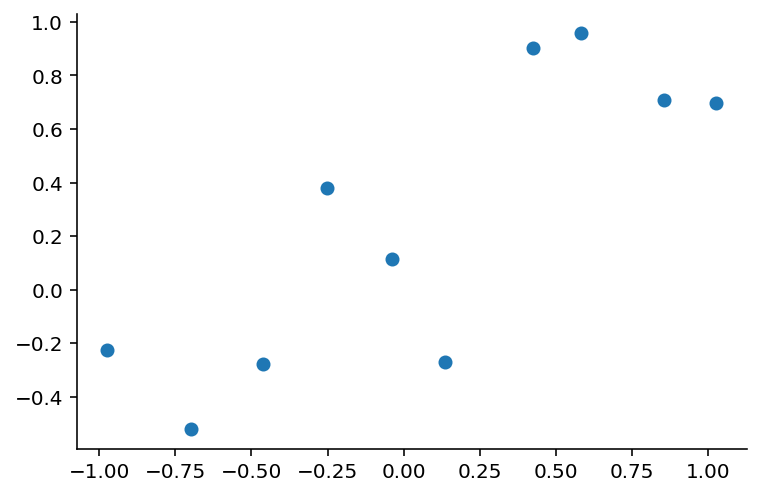

In [6]:
plt.scatter(X[:, 1], Y)

In [7]:
def log_model_evidence(sv, y, X):
    s2, s2_p = sv ** 2
    N, M = X.shape
    I = np.identity(N)
    SN = I + s2_p / s2 * X @ X.T
    logL = -N / 2 * np.log(s2) - np.log(det(SN)) / 2 - y.T @ inv(SN) @ y / (2 * s2)
    return -logL.item()

In [8]:
seed(314)
s0 = np.array([1, 1])
evidence = minimize(log_model_evidence, s0, args=(Y, X))
evidence

      fun: -3.1771786308408503
 hess_inv: array([[ 0.00744077, -0.00167152],
       [-0.00167152,  0.07145749]])
      jac: array([ 2.38418579e-07, -2.32458115e-06])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 10
     njev: 18
   status: 0
  success: True
        x: array([0.3425463 , 0.46253384])

In [9]:
# Estimated σ2 and σ2_p
evidence.x ** 2

array([0.11733797, 0.21393755])

## Kernel parameters

Understanding the prior distribution

$$
    \mu({\bf x}) \sim \mathcal{N}(0, {\bf K})
$$

with ${\bf K}_{i, j} = a\exp\left(-\frac{1}{2\ell^2}(x_i - x_j)^2\right) + b$

In [109]:
def kernel(v, a, b, l):
    return a * np.exp(-v ** 2 / (2 * l ** 2)) + b

In [110]:
x = np.linspace(1, 3, 100)

In [ ]:
x = np.array([1, 2, 3])

mean = np.zeros_like(x)
ν = x[:, None] - x[None, :]
K = k(ν, a=0, b=1, l=1)

det(K)

In [114]:
def build_k(x, k):
    """
    Parameters
    k: function
        Kernel function to evaluate k(xi, xj) ∀ i,j
    ν: np.array(N)
        Array of evaluation points
    """
    v = x[:, None] - x[None, :]
    return k(v)

Note that

* $\ell$ controls the *local* correlation. The bigger $\ell$, the more points will consider as local. When $\ell$ tends to $\infty$, all points will be correlated, hence, they will not vary
* $a$ gives a linear shock of the points, it allows for a greater range of points to be sampled
* $b$ provides a deviation that is independent of the points

With the previous considerations, note that although the first and fourth configuration below have the same structure, they are different in why they arrive at that result:
1. For the first configuration, it is a result of having no consideration of the distance between points, whereas
2. for the second configuration, we have a linear shock of one but we consider all points to be correlated

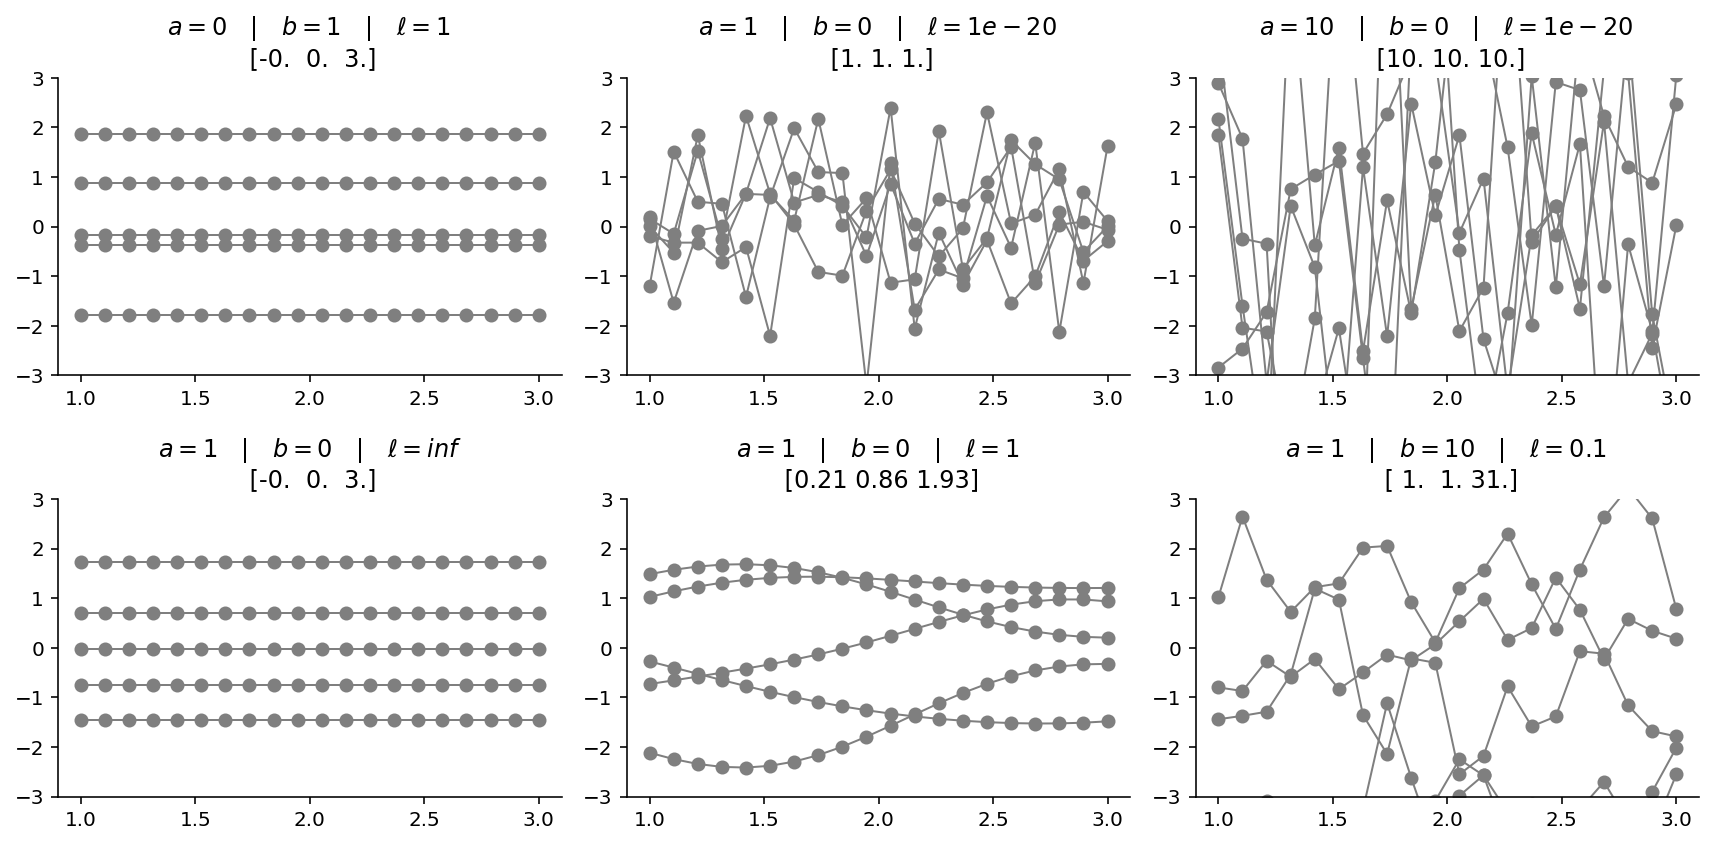

In [426]:
## Singular configuration:
# every predicted point is 
a, b, l = 1, 0.3, 20
x_obs = np.array([1, 2, 3])
x = np.linspace(1, 3, 20)
mean = np.zeros_like(x)

configs = [
    (0, 1, 1),
    (1, 0, 1e-20),
    (10, 0, 1e-20),
    (1, 0, np.inf),
    (1, 0, 1),
    (1, 10, 0.1)
]

seed(314)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()
for axi, (a, b, l) in zip(ax, configs):
    K = build_k(x, lambda v: kernel(v, a, b, l))
    mux = np.random.multivariate_normal(mean=mean, cov=K, size=5)
    axi.plot(x, mux.T, c="tab:gray", alpha=1, marker="o", linewidth=1)
    
    K_obs = build_k(x_obs, lambda v: kernel(v, a, b, l))
    lambdas = eigvalsh(K_obs).round(2)
    axi.set_title(f"$a={a} \quad \\vert \quad b={b} \quad \\vert \quad \ell={l}$ \n {lambdas}")
    axi.set_ylim(-3, 3)
plt.tight_layout()